<a href="https://colab.research.google.com/github/Shuaib11-Github/Projects/blob/main/Detection_of_Fraud_Transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF

from imblearn.under_sampling import TomekLinks, RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [ ]:
df = pd.read_csv('Fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


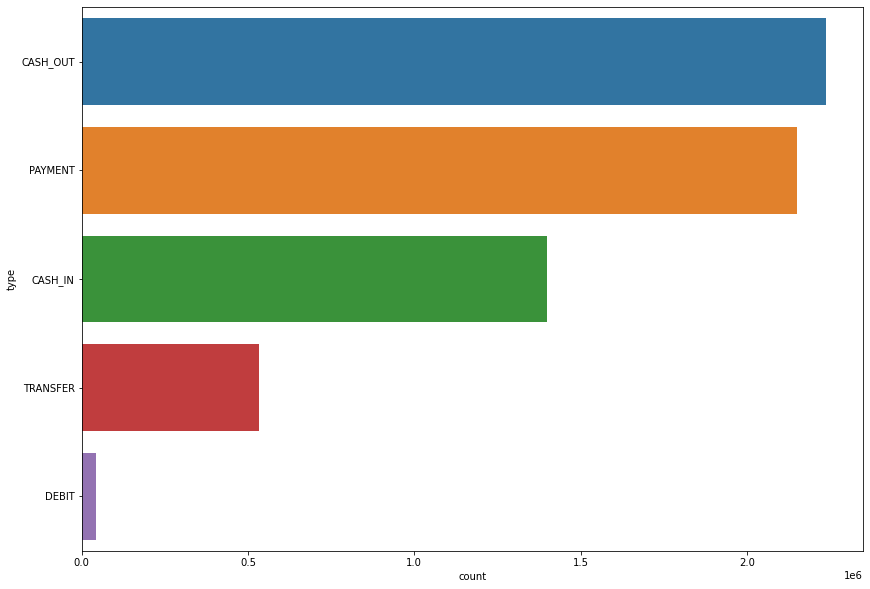

In [ ]:
plt.figure(figsize=(14, 10))

sns.countplot(data=df, y='type', order=df['type'].value_counts().index)
plt.show()

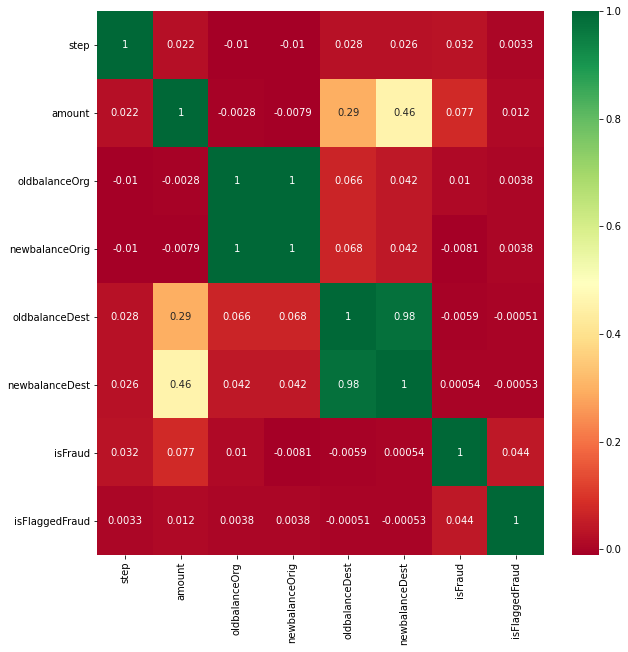

In [ ]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
fold_split = 5

kf = KFold(n_splits=fold_split, random_state=37, shuffle=True)

In [ ]:
fraud_type = df.groupby('type')['isFraud'].value_counts().reset_index(name='Number of trans')
fraud_type

,type,isFraud,Number of trans
0,CASH_IN,0,1399284
1,CASH_OUT,0,2233384
2,CASH_OUT,1,4116
3,DEBIT,0,41432
4,PAYMENT,0,2151495
5,TRANSFER,0,528812
6,TRANSFER,1,4097


- We see that only type='TRANSFER' and type='CASH_OUT' are triggered as Fraud. So we are only interested in checking these columns

In [ ]:
trans_each_acc = df['nameOrig'].value_counts().reset_index(name='Number of trans')
trans_each_acc = trans_each_acc[trans_each_acc['Number of trans'] > 1]

trans_each_acc

,index,Number of trans
0,C1902386530,3
1,C363736674,3
2,C545315117,3
3,C724452879,3
4,C1784010646,3
...,...,...
9293,C1778059576,2
9294,C2049238175,2
9295,C1624916276,2
9296,C1139137575,2


In [ ]:
trans_each_desh = df['nameDest'].value_counts().reset_index(name='Number of trans')
trans_each_desh = trans_each_desh[trans_each_desh['Number of trans'] > 1]

trans_each_desh

,index,Number of trans
0,C1286084959,113
1,C985934102,109
2,C665576141,105
3,C2083562754,102
4,C248609774,101
...,...,...
459653,C2030240815,2
459654,C437804525,2
459655,C1702844447,2
459656,C367899282,2


In [ ]:
acc_fraud = df[df['isFraud']==1]['nameOrig']
dest_fraud = df[df['isFraud']==1]['nameDest'].unique()

dest_fraud

array(['C553264065', 'C38997010', 'C972765878', ..., 'C1365125890',
       'C2080388513', 'C873221189'], dtype=object)

In [ ]:
fraud_in_desh = trans_each_desh[trans_each_desh['index'].isin(dest_fraud)].reset_index(drop=True)
fraud_in_desh

,index,Number of trans
0,C716083600,89
1,C667346055,86
2,C932583850,82
3,C766681183,80
4,C803116137,77
...,...,...
5491,C743070440,2
5492,C1152345873,2
5493,C1054580696,2
5494,C257667736,2


In [ ]:
fraud_in_acc = trans_each_acc[trans_each_acc['index'].isin(acc_fraud)].reset_index(drop=True)
fraud_in_acc

,index,Number of trans
0,C357911107,2
1,C1882162040,2
2,C171834973,2
3,C1885333477,2
4,C803411135,2
5,C1899367925,2
6,C1191696703,2
7,C929585215,2
8,C1044518032,2
9,C10982843,2


One popular trend is fraud attacks by big criminals happen in a short period of time. To check this, we can plot the fraud attacks with time. In our data, we have data every hour. The below graph shows the fraud attack every hour in the 744 hours. As expected there are peaks and troughs and also a very big peak. This suggests that frauds happen in short period of time.

Another analysis that can be interesting is at which hour of a day, the fraud attacks generally happen. From the step variable, we can get the hour of day. The below plot shows the frauds at different hours of day. It tells that frauds happen during sleeping hours the most. Close to 20% of transactions that happen during 4 AM and 5 AM are fraud transactions.

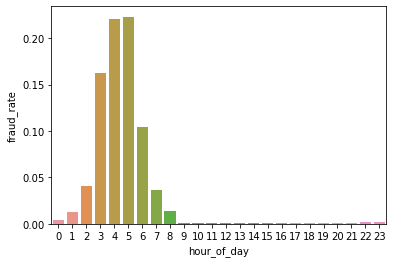

In [ ]:
df["hour_of_day"] = df.step % 24
frauds_hour = pd.concat([df.groupby("hour_of_day")["isFraud"].sum(),df.groupby("hour_of_day")["isFraud"].count()],axis=1)
frauds_hour.columns = ["Frauds","Transactions"]
frauds_hour["fraud_rate"] = frauds_hour.Frauds/frauds_hour.Transactions
sns.barplot(x=frauds_hour.index,y=frauds_hour.fraud_rate)
plt.show()

In [ ]:
frauds_hour

,Frauds,Transactions,fraud_rate
hour_of_day,,,
0,300,71587,0.004191
1,358,27111,0.013205
2,372,9018,0.041251
3,326,2007,0.162431
4,274,1241,0.220790
5,366,1641,0.223035
6,358,3420,0.104678
7,328,8988,0.036493
8,368,26915,0.013673


The below plot shows the total fraud transaction amount on a daily basis

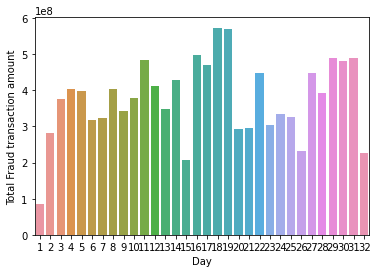

In [ ]:
df["day"] = round(df.step/24)
sns.barplot(x=list(range(1,33)),y=df[df.isFraud==1].groupby("day")["amount"].sum())
plt.xlabel("Day")
plt.ylabel("Total Fraud transaction amount")
plt.show()

We can also see the fraud transactions per day of the week.

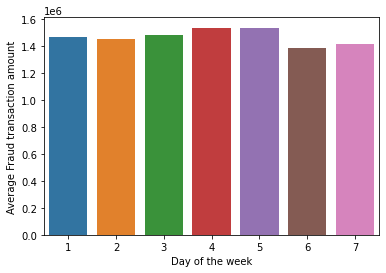

In [ ]:
df["day_of_week"] = df.day % 7
sns.barplot(x=list(range(1,8)),y=df[df.isFraud==1].groupby("day_of_week")["amount"].mean())
plt.xlabel("Day of the week")
plt.ylabel("Average Fraud transaction amount")
plt.show()

In [ ]:
df1 = df.copy()

In [ ]:
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day,day_of_week
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,1,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,1,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,23,31.0,3.0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,23,31.0,3.0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,23,31.0,3.0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,23,31.0,3.0


In [ ]:
df1 = df1[df1['type'].isin(['TRANSFER', 'CASH_OUT'])]
df1.reset_index(drop=True, inplace=True)

feature_name = ['type_' + str(i) for i in df1['type'].unique()]
type_ = pd.get_dummies(df1['type'])
type_.columns = feature_name

df2 = pd.concat([df1, type_], 1)
df2.head()

<ipython-input-111-5b3396847bb5>:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df2 = pd.concat([df1, type_], 1)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day,day_of_week,type_TRANSFER,type_CASH_OUT
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,0.0,0.0,0,1
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,0.0,0.0,1,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,0.0,0.0,1,0
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,0.0,0.0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,0.0,0.0,0,1


In [ ]:
df2['errorBalanceOrig'] = df2['amount'] + df2['newbalanceOrig'] - df2['oldbalanceOrg']
df2['errorBalanceDest'] = df2['amount'] + df2['newbalanceDest'] - df2['oldbalanceDest']

In [ ]:
df2 = df2.drop(['step', 'type', 'nameOrig', 'nameDest', 'type_TRANSFER', 'isFlaggedFraud'], axis=1)
df2

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceOrig,errorBalanceDest
0,181.00,181.00,0.0,0.00,0.00,1,1,0.0,0.0,1,0.00,181.00
1,181.00,181.00,0.0,21182.00,0.00,1,1,0.0,0.0,0,0.00,-21001.00
2,229133.94,15325.00,0.0,5083.00,51513.44,0,1,0.0,0.0,0,213808.94,275564.38
3,215310.30,705.00,0.0,22425.00,0.00,0,1,0.0,0.0,1,214605.30,192885.30
4,311685.89,10835.00,0.0,6267.00,2719172.89,0,1,0.0,0.0,1,300850.89,3024591.78
...,...,...,...,...,...,...,...,...,...,...,...,...
2770404,339682.13,339682.13,0.0,0.00,339682.13,1,23,31.0,3.0,0,0.00,679364.26
2770405,6311409.28,6311409.28,0.0,0.00,0.00,1,23,31.0,3.0,1,0.00,6311409.28
2770406,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,23,31.0,3.0,0,0.00,12622818.55
2770407,850002.52,850002.52,0.0,0.00,0.00,1,23,31.0,3.0,1,0.00,850002.52


In [ ]:
train_df, val_df = train_test_split(df2, test_size=0.25, random_state=37, stratify=df2['isFraud'])
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
print(f'train size: {train_df.shape}, validation size: {val_df.shape}')
val_df.head()

train size: (2077806, 12), validation size: (692603, 12)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceOrig,errorBalanceDest
0,207364.55,40235.0,0.0,2001580.06,2208944.62,0,17,7.0,0.0,0,167129.55,414729.11
1,188058.06,0.0,0.0,638601.98,826660.04,0,17,14.0,0.0,0,188058.06,376116.12
2,947408.14,0.0,0.0,1447307.90,2637226.46,0,18,6.0,6.0,1,947408.14,2137326.70
3,33715.36,0.0,0.0,126043.96,159759.31,0,17,12.0,5.0,0,33715.36,67430.71
4,97464.71,36488.0,0.0,808819.10,906283.81,0,13,10.0,3.0,0,60976.71,194929.42


<AxesSubplot:xlabel='isFraud', ylabel='errorBalanceOrig'>

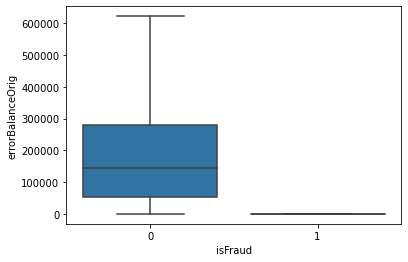

In [ ]:
sns.boxplot(x="isFraud", y="errorBalanceOrig", data=train_df, showfliers=False)

- Interesting to see in the box plots above, we can see that difference between the fraudulent and non-fraudulent data, errordiffOrig shows very contrasting distributions. For isFraud==1, the values tend to be much more negative blow '0', implying that these transactions are indeed moving large amounts of funds out of the originating account. This feature could end up having significant impact on the model predictions.

<AxesSubplot:xlabel='isFraud', ylabel='errorBalanceDest'>

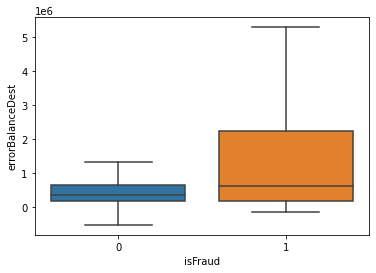

In [ ]:
sns.boxplot(x="isFraud", y="errorBalanceDest", data=train_df, showfliers=False)

The difference is less stark with errordiffDest, and the difference values also tend to be more positive, indicating that the transactions tend to move funds into the destination account.

- A commonality in these last two plots was that the balance difference values for isFraud==1 had more variance and spread. This may be because our sample size for fraudulent data is much smaller. By nature, smaller samples are likely to exhibit higher variability.

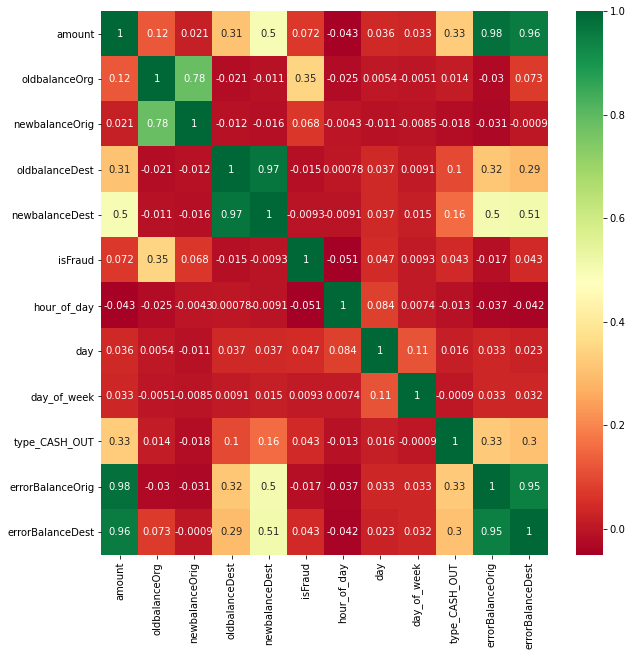

In [ ]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = train_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df.values, i)
                          for i in range(len(train_df.columns))]
  
print(vif_data)

             feature           VIF
0             amount  6.430081e+08
1      oldbalanceOrg  9.624036e+08
2     newbalanceOrig  1.230021e+11
3     oldbalanceDest  2.546814e+09
4     newbalanceDest  3.231749e+08
5            isFraud  1.311942e+00
6        hour_of_day  4.498867e+00
7                day  3.751237e+00
8        day_of_week  2.468546e+00
9      type_CASH_OUT  1.380570e+00
10  errorBalanceOrig  4.284818e+07
11  errorBalanceDest  1.096903e+09


In [ ]:
train_df1 = train_df.drop(['oldbalanceDest', 'oldbalanceOrg', 'errorBalanceOrig', 'amount'], axis=1) # removing some column to overcome multicollinearity
train_df1

,newbalanceOrig,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceDest
0,0.00,1812796.54,0,20,13.0,6.0,0,225195.04
1,0.00,553616.53,0,19,17.0,3.0,0,394955.76
2,0.00,546975.62,0,20,8.0,1.0,0,395064.30
3,9129.57,1543035.05,0,9,16.0,2.0,0,194928.87
4,0.00,105851.23,0,15,15.0,1.0,0,102605.43
...,...,...,...,...,...,...,...,...
2077801,0.00,684069.99,0,17,2.0,2.0,0,366780.40
2077802,0.00,516968.76,0,13,10.0,3.0,0,712046.08
2077803,0.00,346631.33,0,13,10.0,3.0,0,693262.66
2077804,0.00,830291.10,0,0,6.0,6.0,0,261417.47


In [ ]:
val_df1 = val_df.drop(['oldbalanceDest', 'oldbalanceOrg', 'errorBalanceOrig', 'amount'], axis=1) # removing some column to overcome multicollinearity
val_df1

,newbalanceOrig,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceDest
0,0.00,2208944.62,0,17,7.0,0.0,0,414729.11
1,0.00,826660.04,0,17,14.0,0.0,0,376116.12
2,0.00,2637226.46,0,18,6.0,6.0,1,2137326.70
3,0.00,159759.31,0,17,12.0,5.0,0,67430.71
4,0.00,906283.81,0,13,10.0,3.0,0,194929.42
...,...,...,...,...,...,...,...,...
692598,0.00,385989.58,0,11,14.0,0.0,0,374837.18
692599,33045.22,159018.15,0,14,29.0,1.0,0,151389.56
692600,0.00,74473.45,0,17,13.0,6.0,0,148946.90
692601,0.00,3134337.91,0,17,1.0,1.0,0,1510051.79


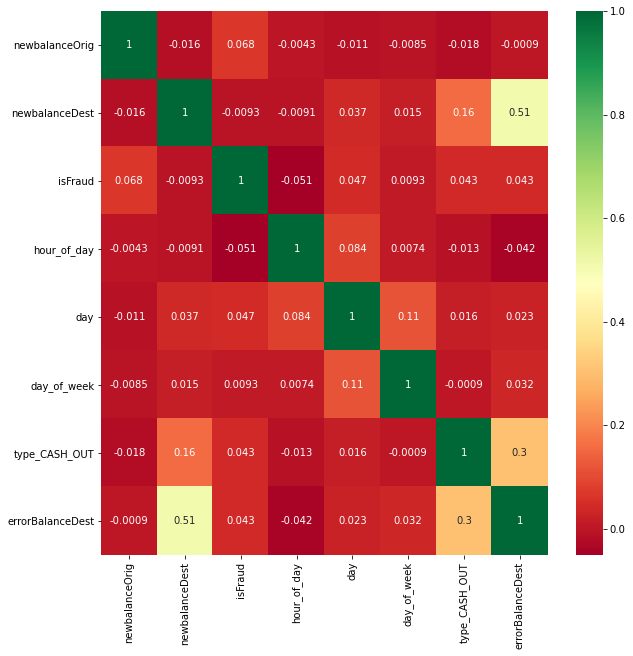

In [ ]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = train_df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(train_df1[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df1.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df1.values, i)
                          for i in range(len(train_df1.columns))]
  
print(vif_data)

            feature       VIF
0    newbalanceOrig  1.015581
1    newbalanceDest  1.607751
2           isFraud  1.015991
3       hour_of_day  4.483857
4               day  3.743511
5       day_of_week  2.468438
6     type_CASH_OUT  1.353001
7  errorBalanceDest  1.616704


In [ ]:
train_df1

,newbalanceOrig,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceDest
0,0.00,1812796.54,0,20,13.0,6.0,0,225195.04
1,0.00,553616.53,0,19,17.0,3.0,0,394955.76
2,0.00,546975.62,0,20,8.0,1.0,0,395064.30
3,9129.57,1543035.05,0,9,16.0,2.0,0,194928.87
4,0.00,105851.23,0,15,15.0,1.0,0,102605.43
...,...,...,...,...,...,...,...,...
2077801,0.00,684069.99,0,17,2.0,2.0,0,366780.40
2077802,0.00,516968.76,0,13,10.0,3.0,0,712046.08
2077803,0.00,346631.33,0,13,10.0,3.0,0,693262.66
2077804,0.00,830291.10,0,0,6.0,6.0,0,261417.47


In [ ]:
val_df1

,newbalanceOrig,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceDest
0,0.00,2208944.62,0,17,7.0,0.0,0,414729.11
1,0.00,826660.04,0,17,14.0,0.0,0,376116.12
2,0.00,2637226.46,0,18,6.0,6.0,1,2137326.70
3,0.00,159759.31,0,17,12.0,5.0,0,67430.71
4,0.00,906283.81,0,13,10.0,3.0,0,194929.42
...,...,...,...,...,...,...,...,...
692598,0.00,385989.58,0,11,14.0,0.0,0,374837.18
692599,33045.22,159018.15,0,14,29.0,1.0,0,151389.56
692600,0.00,74473.45,0,17,13.0,6.0,0,148946.90
692601,0.00,3134337.91,0,17,1.0,1.0,0,1510051.79


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df1.values, i)
                          for i in range(len(train_df1.columns))]
  
print(vif_data)

          feature       VIF
0          amount  1.653540
1  newbalanceOrig  1.016767
2  newbalanceDest  1.583007
3         isFraud  1.019743
4     hour_of_day  4.484359
5             day  3.745450
6     day_of_week  2.468389
7   type_CASH_OUT  1.377170


1. Data cleaning including missing values, outliers and multi-collinearity?
- Ans: There are no missing values, Multicollinearity has been removed using VIF and treatment of outliers
  - We can see that there are some variables with high correlation,
  
     - 'errorBalanceOrg' and errorBalanceDest' are highly correlated.
     - 'type_TRANSFER' and 'type_CASH_OUT' high negative correlation.
     - 'oldbalanceDest' and 'newbalanceDest' are highly correlated.
     
  - We can drop this columns and do our Further Analysis.

### Important Observations

In [ ]:
train_df[(train_df['amount']<100) & (train_df['isFraud']==1)]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_TRANSFER,type_CASH_OUT,errorBalanceOrig,errorBalanceDest
6829,0.0,0.0,0.0,0.00,0.00,1,17,26.0,5.0,1,0,0.0,0.0
120265,0.0,0.0,0.0,76759.90,76759.90,1,17,18.0,4.0,1,0,0.0,0.0
175305,0.0,0.0,0.0,1328472.86,1328472.86,1,10,24.0,3.0,1,0,0.0,0.0
219306,0.0,0.0,0.0,0.00,0.00,1,22,27.0,6.0,1,0,0.0,0.0
351096,0.0,0.0,0.0,230289.66,230289.66,1,2,23.0,2.0,1,0,0.0,0.0
397217,0.0,0.0,0.0,27938.72,27938.72,1,23,28.0,0.0,1,0,0.0,0.0
806728,0.0,0.0,0.0,0.00,0.00,1,10,10.0,3.0,1,0,0.0,0.0
869551,63.8,63.8,0.0,0.00,63.80,1,15,15.0,1.0,1,0,-63.8,63.8
903815,0.0,0.0,0.0,267522.87,267522.87,1,21,31.0,3.0,1,0,0.0,0.0
922913,0.0,0.0,0.0,0.00,0.00,1,22,27.0,6.0,1,0,0.0,0.0


- The data has lot of values where it is reported as fraud even though there is no suspicious activity happened. There is a need for further investigation about these data points about they being reportee as fraud. 
- For example customers like 'nameOrig'='C1971175979' and 'nameDest'='C1352345416'. There are some other data points that are similar to above example, so there is a need of need for further investigation about these kind of points being reported as Fraud.

In [ ]:
features = ['newbalanceOrig',
            'newbalanceDest',
            'type_CASH_OUT',
            'day_of_week',
            'day',
            'hour_of_day',
            'errorBalanceDest']

label = ['isFraud']

In [ ]:
X_train, X_test = train_df1[features], val_df1[features]
y_train, y_test = train_df1[label], val_df1[label]

In [ ]:
column_train = [i for i in X_train.columns]

print(column_train)

['newbalanceOrig', 'newbalanceDest', 'type_CASH_OUT', 'day_of_week', 'day', 'hour_of_day', 'errorBalanceDest']


In [ ]:
columns_normalize = [i for i in column_train if isinstance(X_train.loc[0, i], np.float64)] # returns columns which has 'float64' datatype.

def normalize(col, type_='StandardScaler'):
    
    if type_ == 'StandardScaler':
        clf = StandardScaler()
    elif type_ == 'MinMaxScaler':
        clf = MinMaxScaler()
    elif type_ == 'RobustScaler':
        clf = RobustScaler()
    else:
        print('Error type in!')
    
    X_train[col] = clf.fit_transform(X_train[col])
    X_test[col] = clf.transform(X_test[col])
    
    return X_train, X_test
    
X_train, X_test = normalize(columns_normalize)
X_test.head()

C:\Users\iamfa\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\iamfa\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,newbalanceOrig,newbalanceDest,type_CASH_OUT,day_of_week,day,hour_of_day,errorBalanceDest
0,-0.105108,0.034095,0,-1.260603,-0.541974,17,-0.124714
1,-0.105108,-0.260960,0,-1.260603,0.641677,17,-0.144196
2,-0.105108,0.125513,1,1.738742,-0.711067,18,0.744429
3,-0.105108,-0.403312,0,1.238851,0.303491,17,-0.299945
4,-0.105108,-0.243964,0,0.239069,-0.034695,13,-0.235615


In [ ]:
def scatter_draw(data, feature1, feature2, feature3, fraud_feature):
    
    data_normal = data[fraud_feature==0]
    data_fraud = data[fraud_feature==1]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(data_normal[feature1], data_normal[feature2], data_normal[feature3], marker='o', c='blue', label='normal')
    ax.scatter(data_fraud[feature1], data_fraud[feature2], data_fraud[feature3], marker='o', c='red', label='fraud')
    
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(feature3)
    
    plt.legend(loc='upper left')
    
    plt.show()
    


def roc_line(preds, titles):
    
    plt.figure(figsize=(10, 10))
    label = y_test
    for pred, title in zip(preds, titles):
        fpr, tpr, threshold = roc_curve(label, pred)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{title}: {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
        plt.legend(loc='lower right')
        plt.xlabel('False Positive Rate ')
        plt.ylabel('True Positive Rate')
        plt.show()
    
    
    
def heatmap_cal(pred):
    
    confusion = confusion_matrix(y_test.values, pred)
    print(classification_report(y_test.values, pred))
    print(55*'-')
    sns.heatmap(confusion, annot=True, annot_kws={"size": 16}, fmt='.0f')
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    plt.show()
    
    
def feature_important(importances):
    
    data = pd.DataFrame({'feature': column_train, 'important': importances})
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    sns.barplot(data=data.sort_values('important', ascending=False), x='important', y='feature')
    plt.xlabel('Relative Importance')
    plt.show()
    
    return data

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
fraud_ratio = np.count_nonzero(train_df['isFraud'])/len(train_df)
print(fraud_ratio)

0.0029646656136328416


### Isolation Forest

In [ ]:
isolation = IForest(contamination=fraud_ratio)
isolation.fit(X_train.loc[:, column_train])

pred_isolation = isolation.predict(X_test.loc[:, column_train])
pred_prob_isolation = isolation.predict_proba(X_test.loc[:, column_train])
print(f'Number of abnormal detection: {np.count_nonzero(pred_isolation)}')

Number of abnormal detection: 2108


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       0.04      0.04      0.04      2053

    accuracy                           0.99    692603
   macro avg       0.52      0.52      0.52    692603
weighted avg       0.99      0.99      0.99    692603

-------------------------------------------------------


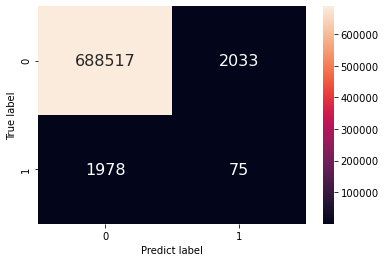

In [ ]:
heatmap_cal(pred_isolation)

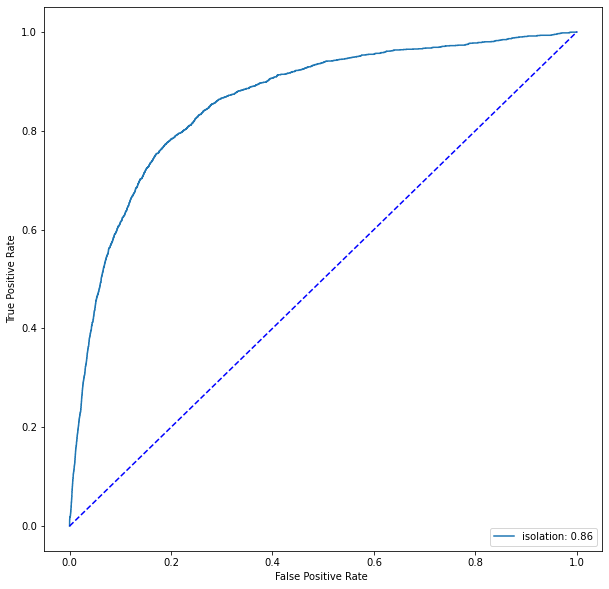

In [ ]:
roc_line([pred_prob_isolation[:, 1]], ['isolation'])

### Model Buliding

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
y_pred = dt.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.9999995187231147
0.998414676228662
[[2071646       0]
 [      1    6159]]
[[690003    547]
 [   551   1502]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       0.73      0.73      0.73      2053

    accuracy                           1.00    692603
   macro avg       0.87      0.87      0.87    692603
weighted avg       1.00      1.00      1.00    692603



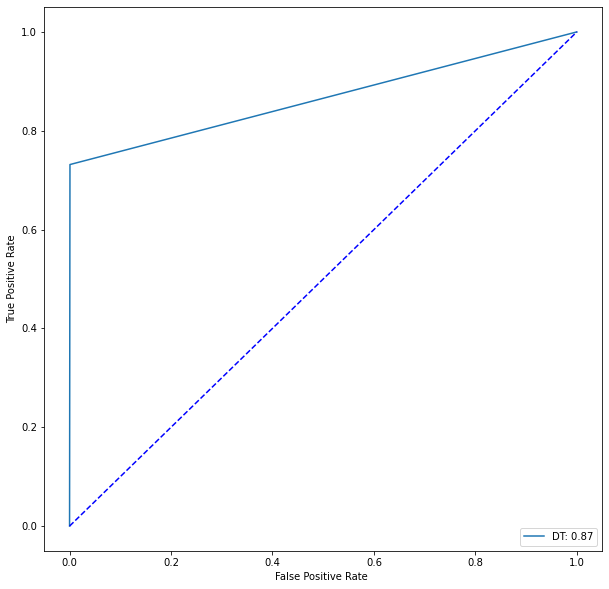

In [ ]:
pred_prob_dt = dt.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_dt[:, 1]], ['DT'])

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
y_pred = lr.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

C:\Users\iamfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9971941557585261
0.9971744274858757
[[2071607      39]
 [   5791     369]]
[[690530     20]
 [  1937    116]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       0.85      0.06      0.11      2053

    accuracy                           1.00    692603
   macro avg       0.93      0.53      0.55    692603
weighted avg       1.00      1.00      1.00    692603



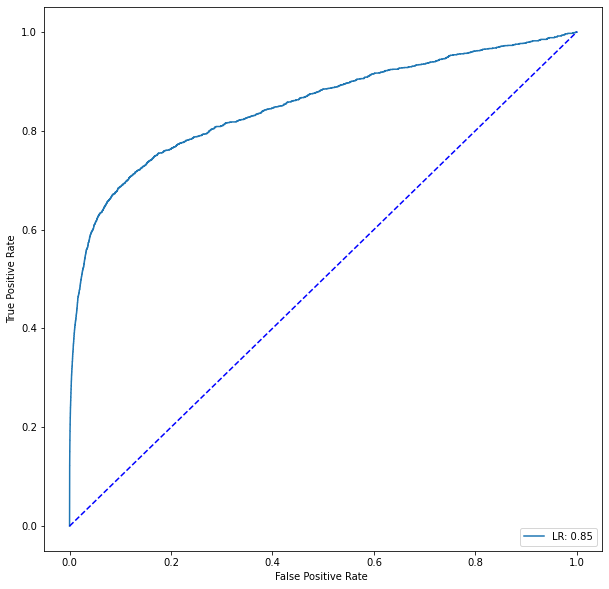

In [ ]:
pred_prob_lr = lr.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_lr[:, 1]], ['LR'])

### XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
xgb = XGBClassifier(n_estimators=100, max_depth=25, criterion='gini', learning_rate=0.02, eval_metric='auc')
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
y_pred = xgb.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

C:\Users\iamfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[21:37:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9992333259216692
0.9990398540000549
[[2071552      94]
 [   1499    4661]]
[[690470     80]
 [   585   1468]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       0.95      0.72      0.82      2053

    accuracy                           1.00    692603
   macro avg       0.97      0.86      0.91    692603
weighted avg       1.00      1.00      1.00    692603



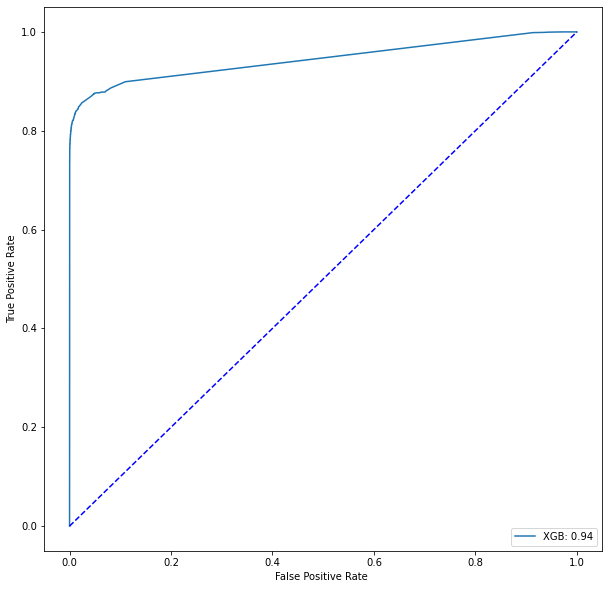

In [ ]:
pred_prob_xgb = xgb.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_xgb[:, 1]], ['XGB'])

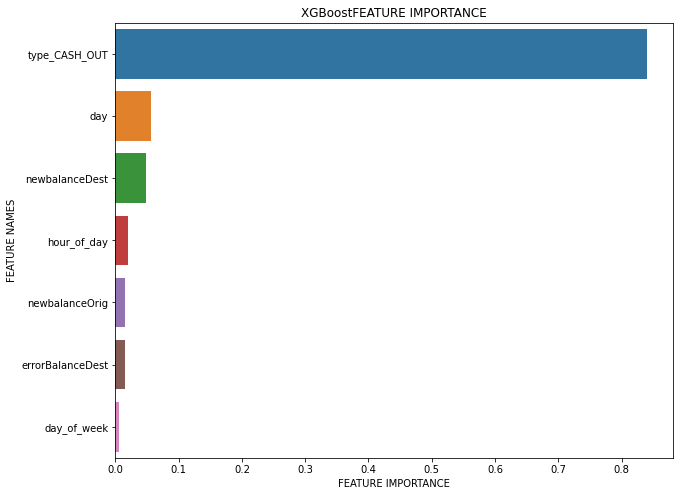

In [ ]:
plot_feature_importance(xgb.feature_importances_, X_train.columns, 'XGBoost')

### CatBoost Classifier

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
cb = CatBoostClassifier(iterations=500, depth=8, l2_leaf_reg=3, loss_function='CrossEntropy')
cb.fit(X_train, y_train)
pred = cb.predict(X_test)
y_pred = cb.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0:	learn: 0.5910974	total: 587ms	remaining: 4m 52s
1:	learn: 0.5014249	total: 1.25s	remaining: 5m 10s
2:	learn: 0.4298522	total: 1.72s	remaining: 4m 44s
3:	learn: 0.3656371	total: 2.28s	remaining: 4m 42s
4:	learn: 0.3127881	total: 3s	remaining: 4m 56s
5:	learn: 0.2618291	total: 3.62s	remaining: 4m 58s
6:	learn: 0.2237504	total: 4.26s	remaining: 5m
7:	learn: 0.1906359	total: 4.88s	remaining: 4m 59s
8:	learn: 0.1621796	total: 5.5s	remaining: 5m
9:	learn: 0.1392053	total: 6.13s	remaining: 5m
10:	learn: 0.1207575	total: 6.78s	remaining: 5m 1s
11:	learn: 0.1042968	total: 7.39s	remaining: 5m
12:	learn: 0.0904829	total: 8.01s	remaining: 5m
13:	learn: 0.0792550	total: 8.63s	remaining: 4m 59s
14:	learn: 0.0695452	total: 9.24s	remaining: 4m 58s
15:	learn: 0.0608696	total: 9.91s	remaining: 4m 59s
16:	learn: 0.0538591	total: 10.5s	remaining: 4m 58s
17:	learn: 0.0476361	total: 11.2s	remaining: 4m 59s
18:	learn: 0.0422567	total: 11.8s	remaining: 4m 58s
19:	learn: 0.0378987	total: 12.4s	remaining: 4m

157:	learn: 0.0054125	total: 1m 45s	remaining: 3m 48s
158:	learn: 0.0054088	total: 1m 46s	remaining: 3m 47s
159:	learn: 0.0054020	total: 1m 46s	remaining: 3m 47s
160:	learn: 0.0053972	total: 1m 47s	remaining: 3m 47s
161:	learn: 0.0053919	total: 1m 48s	remaining: 3m 46s
162:	learn: 0.0053877	total: 1m 49s	remaining: 3m 46s
163:	learn: 0.0053820	total: 1m 50s	remaining: 3m 45s
164:	learn: 0.0053773	total: 1m 50s	remaining: 3m 44s
165:	learn: 0.0053736	total: 1m 51s	remaining: 3m 44s
166:	learn: 0.0053689	total: 1m 52s	remaining: 3m 43s
167:	learn: 0.0053662	total: 1m 52s	remaining: 3m 42s
168:	learn: 0.0053575	total: 1m 53s	remaining: 3m 42s
169:	learn: 0.0053533	total: 1m 54s	remaining: 3m 42s
170:	learn: 0.0053508	total: 1m 55s	remaining: 3m 42s
171:	learn: 0.0053471	total: 1m 56s	remaining: 3m 42s
172:	learn: 0.0053443	total: 1m 57s	remaining: 3m 42s
173:	learn: 0.0053410	total: 1m 58s	remaining: 3m 41s
174:	learn: 0.0053364	total: 1m 58s	remaining: 3m 40s
175:	learn: 0.0053325	total:

310:	learn: 0.0048851	total: 3m 39s	remaining: 2m 13s
311:	learn: 0.0048831	total: 3m 40s	remaining: 2m 12s
312:	learn: 0.0048762	total: 3m 41s	remaining: 2m 12s
313:	learn: 0.0048735	total: 3m 42s	remaining: 2m 11s
314:	learn: 0.0048697	total: 3m 43s	remaining: 2m 11s
315:	learn: 0.0048672	total: 3m 43s	remaining: 2m 10s
316:	learn: 0.0048656	total: 3m 44s	remaining: 2m 9s
317:	learn: 0.0048634	total: 3m 45s	remaining: 2m 8s
318:	learn: 0.0048602	total: 3m 45s	remaining: 2m 8s
319:	learn: 0.0048578	total: 3m 46s	remaining: 2m 7s
320:	learn: 0.0048563	total: 3m 47s	remaining: 2m 6s
321:	learn: 0.0048525	total: 3m 47s	remaining: 2m 5s
322:	learn: 0.0048513	total: 3m 48s	remaining: 2m 5s
323:	learn: 0.0048498	total: 3m 49s	remaining: 2m 4s
324:	learn: 0.0048485	total: 3m 50s	remaining: 2m 3s
325:	learn: 0.0048471	total: 3m 50s	remaining: 2m 3s
326:	learn: 0.0048458	total: 3m 51s	remaining: 2m 2s
327:	learn: 0.0048442	total: 3m 52s	remaining: 2m 1s
328:	learn: 0.0048426	total: 3m 52s	rema

465:	learn: 0.0046065	total: 5m 29s	remaining: 24s
466:	learn: 0.0046055	total: 5m 29s	remaining: 23.3s
467:	learn: 0.0046044	total: 5m 30s	remaining: 22.6s
468:	learn: 0.0046011	total: 5m 31s	remaining: 21.9s
469:	learn: 0.0045987	total: 5m 31s	remaining: 21.2s
470:	learn: 0.0045970	total: 5m 32s	remaining: 20.5s
471:	learn: 0.0045960	total: 5m 33s	remaining: 19.8s
472:	learn: 0.0045951	total: 5m 33s	remaining: 19.1s
473:	learn: 0.0045942	total: 5m 34s	remaining: 18.4s
474:	learn: 0.0045933	total: 5m 35s	remaining: 17.6s
475:	learn: 0.0045921	total: 5m 35s	remaining: 16.9s
476:	learn: 0.0045913	total: 5m 36s	remaining: 16.2s
477:	learn: 0.0045897	total: 5m 37s	remaining: 15.5s
478:	learn: 0.0045885	total: 5m 38s	remaining: 14.8s
479:	learn: 0.0045873	total: 5m 38s	remaining: 14.1s
480:	learn: 0.0045864	total: 5m 39s	remaining: 13.4s
481:	learn: 0.0045846	total: 5m 40s	remaining: 12.7s
482:	learn: 0.0045842	total: 5m 41s	remaining: 12s
483:	learn: 0.0045838	total: 5m 42s	remaining: 11.

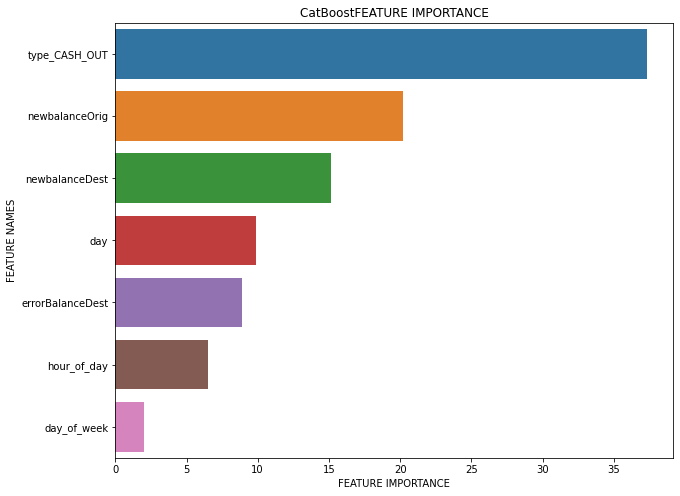

In [ ]:
plot_feature_importance(cb.feature_importances_, X_train.columns, 'CatBoost')

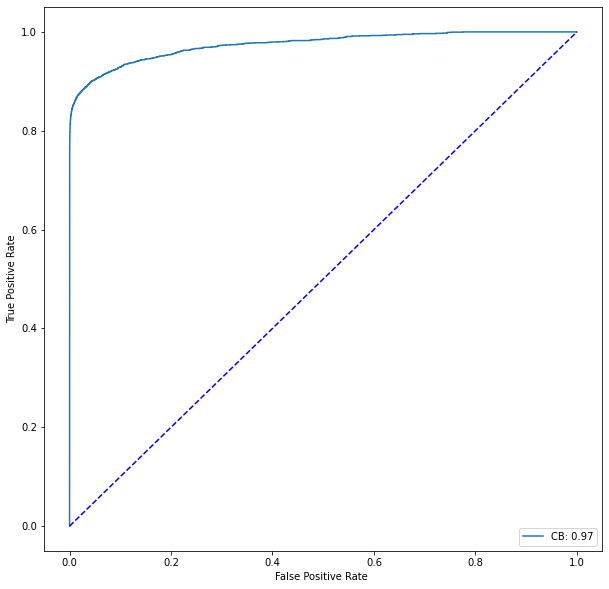

In [ ]:
pred_prob_cb = cb.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_cb[:, 1]], ['CB'])

### LigthGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
lgb = LGBMClassifier(n_estimators=1000, max_depth=25, learning_rate=0.01, eval_metric='auc', objective='binary', boosting='gbdt')
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)
y_pred = lgb.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

C:\Users\iamfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.9991736475878884
0.9991091577714795
[[2071410     236]
 [   1481    4679]]
[[690466     84]
 [   533   1520]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690550
           1       0.95      0.74      0.83      2053

    accuracy                           1.00    692603
   macro avg       0.97      0.87      0.92    692603
weighted avg       1.00      1.00      1.00    692603



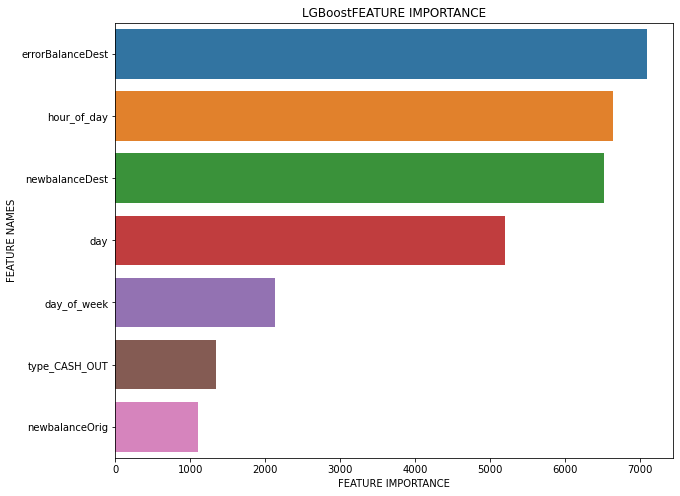

In [ ]:
plot_feature_importance(lgb.feature_importances_, X_train.columns, 'LGBoost')

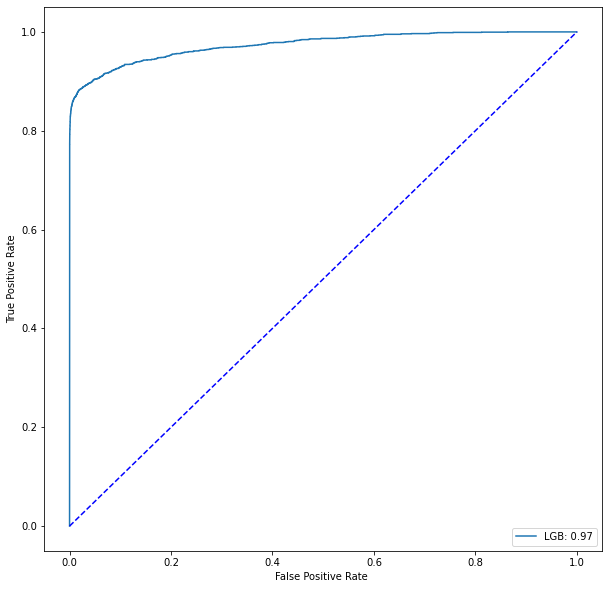

In [ ]:
pred_prob_lgb = lgb.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_lgb[:, 1]], ['LGB'])

### Balancing the dataset using SMOTE and applying the algorithms

In [ ]:
df2

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceOrig,errorBalanceDest
0,181.00,181.00,0.0,0.00,0.00,1,1,0.0,0.0,1,0.00,181.00
1,181.00,181.00,0.0,21182.00,0.00,1,1,0.0,0.0,0,0.00,-21001.00
2,229133.94,15325.00,0.0,5083.00,51513.44,0,1,0.0,0.0,0,213808.94,275564.38
3,215310.30,705.00,0.0,22425.00,0.00,0,1,0.0,0.0,1,214605.30,192885.30
4,311685.89,10835.00,0.0,6267.00,2719172.89,0,1,0.0,0.0,1,300850.89,3024591.78
...,...,...,...,...,...,...,...,...,...,...,...,...
2770404,339682.13,339682.13,0.0,0.00,339682.13,1,23,31.0,3.0,0,0.00,679364.26
2770405,6311409.28,6311409.28,0.0,0.00,0.00,1,23,31.0,3.0,1,0.00,6311409.28
2770406,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,23,31.0,3.0,0,0.00,12622818.55
2770407,850002.52,850002.52,0.0,0.00,0.00,1,23,31.0,3.0,1,0.00,850002.52


### Checking for multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df2.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df2.values, i)
                          for i in range(len(df2.columns))]
  
print(vif_data)

             feature           VIF
0             amount  2.129474e+09
1      oldbalanceOrg  2.273035e+08
2     newbalanceOrig  1.086488e+09
3     oldbalanceDest  2.812532e+08
4     newbalanceDest  6.687516e+07
5            isFraud  1.308751e+00
6        hour_of_day  4.499943e+00
7                day  3.749083e+00
8        day_of_week  2.467982e+00
9      type_CASH_OUT  1.378997e+00
10  errorBalanceOrig  2.305837e+07
11  errorBalanceDest  8.913004e+08


In [ ]:
df2 = df2.drop(['oldbalanceDest', 'oldbalanceOrg', 'errorBalanceOrig', 'amount'], axis=1)
df2

,newbalanceOrig,newbalanceDest,isFraud,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceDest
0,0.0,0.00,1,1,0.0,0.0,1,181.00
1,0.0,0.00,1,1,0.0,0.0,0,-21001.00
2,0.0,51513.44,0,1,0.0,0.0,0,275564.38
3,0.0,0.00,0,1,0.0,0.0,1,192885.30
4,0.0,2719172.89,0,1,0.0,0.0,1,3024591.78
...,...,...,...,...,...,...,...,...
2770404,0.0,339682.13,1,23,31.0,3.0,0,679364.26
2770405,0.0,0.00,1,23,31.0,3.0,1,6311409.28
2770406,0.0,6379898.11,1,23,31.0,3.0,0,12622818.55
2770407,0.0,0.00,1,23,31.0,3.0,1,850002.52


### Removing columns with multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df2.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df2.values, i)
                          for i in range(len(df2.columns))]
  
print(vif_data)

          feature       VIF
0          amount  1.649293
1  newbalanceOrig  1.016205
2  newbalanceDest  1.584834
3         isFraud  1.018871
4     hour_of_day  4.485242
5             day  3.743383
6     day_of_week  2.467815
7   type_CASH_OUT  1.375856


In [ ]:
X, y = df2.drop('isFraud', axis=1), df2['isFraud']

In [ ]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=37, stratify=y_sm)

In [ ]:
column_train = [i for i in X_train.columns]

print(column_train)

['newbalanceOrig', 'newbalanceDest', 'hour_of_day', 'day', 'day_of_week', 'type_CASH_OUT', 'errorBalanceDest']


### Scaling the data

In [ ]:
columns_normalize = [i for i in column_train if isinstance(X_train.loc[0, i], np.float64)] # returns columns which has 'float64' datatype.

def normalize(col, type_='StandardScaler'):
    
    if type_ == 'StandardScaler':
        clf = StandardScaler()
    elif type_ == 'MinMaxScaler':
        clf = MinMaxScaler()
    elif type_ == 'RobustScaler':
        clf = RobustScaler()
    else:
        print('Error type in!')
    
    X_train[col] = clf.fit_transform(X_train[col])
    X_test[col] = clf.transform(X_test[col])
    
    return X_train, X_test
    
X_train, X_test = normalize(columns_normalize)
X_test.head()

C:\Users\iamfa\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\iamfa\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,newbalanceOrig,newbalanceDest,hour_of_day,day,day_of_week,type_CASH_OUT,errorBalanceDest
2025066,-0.074826,-0.377795,17,0.169179,-1.483689,0,-0.379758
3089434,-0.074826,-0.405721,12,0.838999,1.682603,1,-0.402485
1896751,-0.074826,-0.376038,20,0.029794,1.829159,0,-0.433504
2687274,-0.074826,-0.378278,22,1.423641,-0.379406,0,-0.437074
745329,-0.074826,-0.070660,15,-0.806514,-1.483689,0,-0.225326


In [ ]:
fraud_ratio = np.count_nonzero(y_train)/len(y_train)
print(fraud_ratio)

0.5


### Isolation Forest

In [ ]:
isolation = IForest(contamination=fraud_ratio)
isolation.fit(X_train.loc[:, column_train])

pred_isolation = isolation.predict(X_test.loc[:, column_train])
pred_prob_isolation = isolation.predict_proba(X_test.loc[:, column_train])
print(f'Number of abnormal detection: {np.count_nonzero(pred_isolation)}')

Number of abnormal detection: 692350


              precision    recall  f1-score   support

           0       0.65      0.64      0.65    690549
           1       0.65      0.65      0.65    690549

    accuracy                           0.65   1381098
   macro avg       0.65      0.65      0.65   1381098
weighted avg       0.65      0.65      0.65   1381098

-------------------------------------------------------


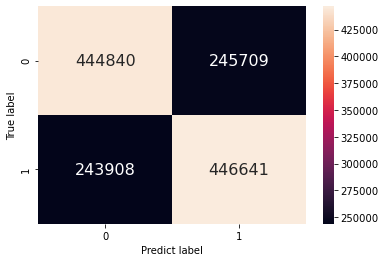

In [ ]:
heatmap_cal(pred_isolation)

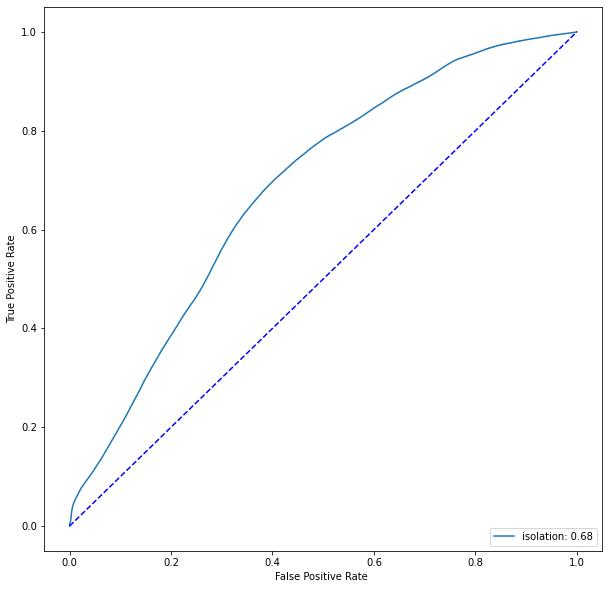

In [ ]:
roc_line([pred_prob_isolation[:, 1]], ['isolation'])

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
y_pred = dt.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.99999951729228
0.9989978987732949
[[2071646       1]
 [      1 2071646]]
[[689837    712]
 [   672 689877]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690549
           1       1.00      1.00      1.00    690549

    accuracy                           1.00   1381098
   macro avg       1.00      1.00      1.00   1381098
weighted avg       1.00      1.00      1.00   1381098



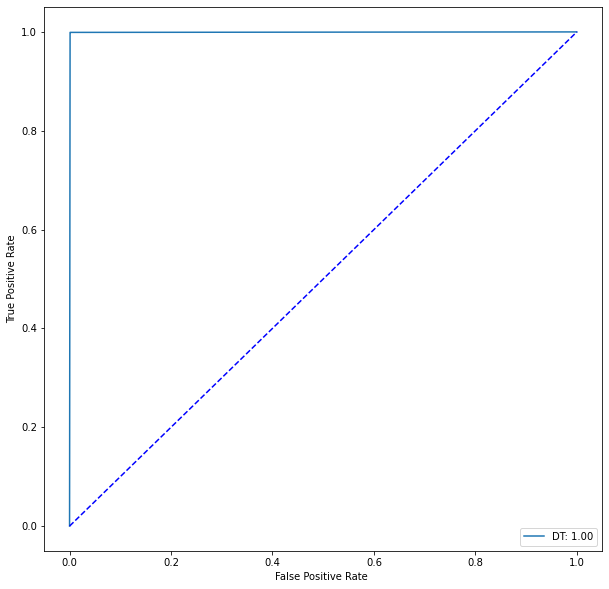

In [ ]:
pred_prob_dt = dt.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_dt[:, 1]], ['DT'])

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
y_pred = lr.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.8045055455876411
0.8036279829526941
[[1728071  343576]
 [ 466415 1605232]]
[[575071 115478]
 [155731 534818]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81    690549
           1       0.82      0.77      0.80    690549

    accuracy                           0.80   1381098
   macro avg       0.80      0.80      0.80   1381098
weighted avg       0.80      0.80      0.80   1381098



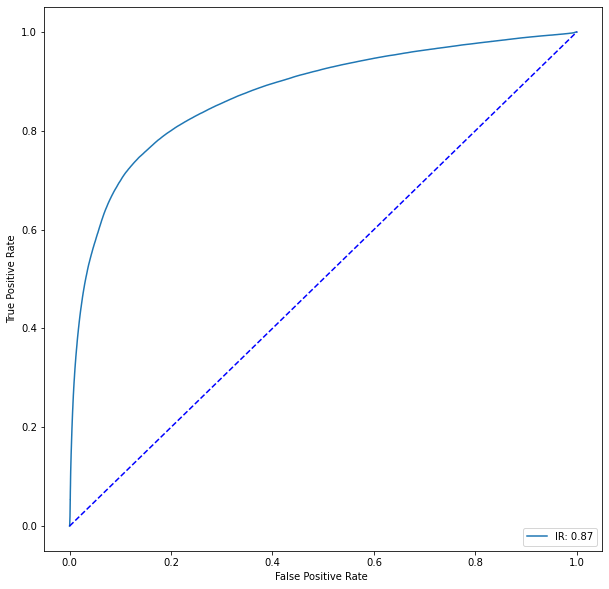

In [ ]:
pred_prob_lr = lr.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_lr[:, 1]], ['lR'])

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
xgb = XGBClassifier(n_estimators=100, max_depth=25, criterion='gini', learning_rate=0.02, eval_metric='auc')
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
y_pred = xgb.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[22:01:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9993382077158898
0.9990196206206946
[[2070602    1045]
 [   1697 2069950]]
[[689972    577]
 [   777 689772]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690549
           1       1.00      1.00      1.00    690549

    accuracy                           1.00   1381098
   macro avg       1.00      1.00      1.00   1381098
weighted avg       1.00      1.00      1.00   1381098



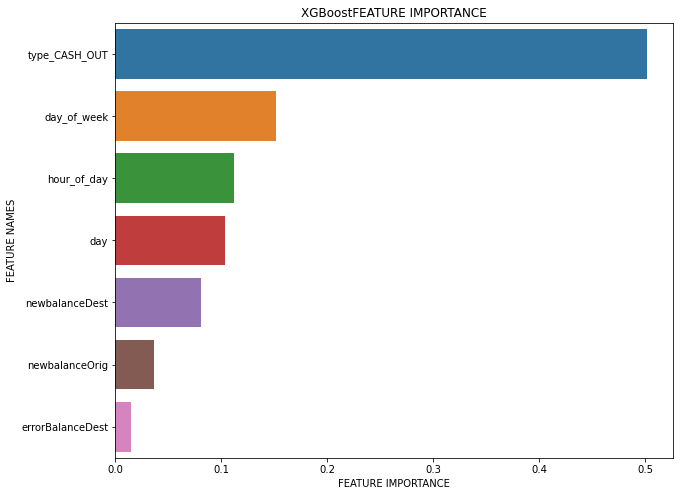

In [ ]:
plot_feature_importance(xgb.feature_importances_, X_train.columns, 'XGBoost')

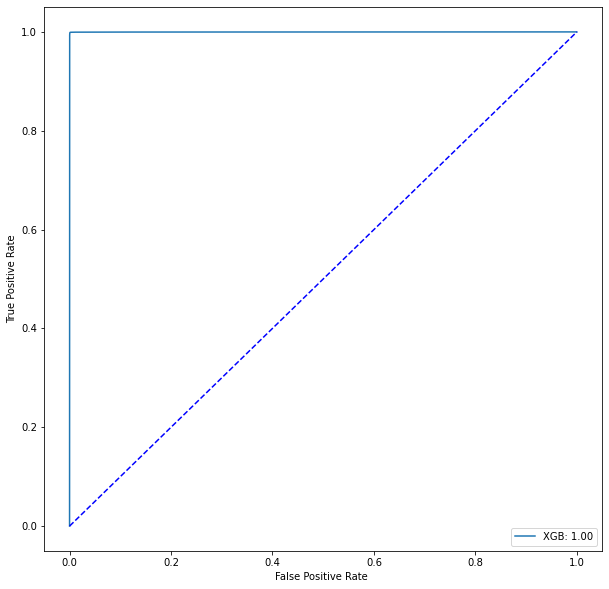

In [ ]:
pred_prob_xgb = xgb.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_xgb[:, 1]], ['XGB'])

### Cat Boost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
cb = CatBoostClassifier(iterations=500, depth=8, l2_leaf_reg=3, loss_function='CrossEntropy')
cb.fit(X_train, y_train)
pred = cb.predict(X_test)
y_pred = cb.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0:	learn: 0.6266258	total: 1.3s	remaining: 10m 47s
1:	learn: 0.5717693	total: 2.56s	remaining: 10m 37s
2:	learn: 0.5214775	total: 3.79s	remaining: 10m 28s
3:	learn: 0.4800218	total: 5.11s	remaining: 10m 33s
4:	learn: 0.4443557	total: 6.36s	remaining: 10m 30s
5:	learn: 0.4123270	total: 7.63s	remaining: 10m 28s
6:	learn: 0.3846227	total: 8.88s	remaining: 10m 25s
7:	learn: 0.3626513	total: 10.1s	remaining: 10m 21s
8:	learn: 0.3434048	total: 11.3s	remaining: 10m 18s
9:	learn: 0.3248551	total: 12.6s	remaining: 10m 15s
10:	learn: 0.3078632	total: 13.8s	remaining: 10m 15s
11:	learn: 0.2932194	total: 15.2s	remaining: 10m 16s
12:	learn: 0.2796004	total: 16.4s	remaining: 10m 15s
13:	learn: 0.2680949	total: 17.7s	remaining: 10m 14s
14:	learn: 0.2578402	total: 19s	remaining: 10m 13s
15:	learn: 0.2479939	total: 20.2s	remaining: 10m 11s
16:	learn: 0.2404297	total: 21.5s	remaining: 10m 10s
17:	learn: 0.2311728	total: 22.8s	remaining: 10m 10s
18:	learn: 0.2245609	total: 24s	remaining: 10m 8s
19:	learn

156:	learn: 0.0430490	total: 3m 21s	remaining: 7m 19s
157:	learn: 0.0427658	total: 3m 22s	remaining: 7m 18s
158:	learn: 0.0426250	total: 3m 23s	remaining: 7m 17s
159:	learn: 0.0424634	total: 3m 25s	remaining: 7m 16s
160:	learn: 0.0423307	total: 3m 26s	remaining: 7m 14s
161:	learn: 0.0422321	total: 3m 27s	remaining: 7m 13s
162:	learn: 0.0421328	total: 3m 29s	remaining: 7m 12s
163:	learn: 0.0420356	total: 3m 30s	remaining: 7m 10s
164:	learn: 0.0417721	total: 3m 31s	remaining: 7m 9s
165:	learn: 0.0417156	total: 3m 32s	remaining: 7m 8s
166:	learn: 0.0414370	total: 3m 34s	remaining: 7m 7s
167:	learn: 0.0411047	total: 3m 35s	remaining: 7m 6s
168:	learn: 0.0410056	total: 3m 36s	remaining: 7m 4s
169:	learn: 0.0408932	total: 3m 38s	remaining: 7m 3s
170:	learn: 0.0406120	total: 3m 39s	remaining: 7m 2s
171:	learn: 0.0403678	total: 3m 40s	remaining: 7m 1s
172:	learn: 0.0403097	total: 3m 42s	remaining: 7m
173:	learn: 0.0401549	total: 3m 43s	remaining: 6m 58s
174:	learn: 0.0399408	total: 3m 44s	rema

309:	learn: 0.0252363	total: 6m 45s	remaining: 4m 8s
310:	learn: 0.0251394	total: 6m 46s	remaining: 4m 7s
311:	learn: 0.0251224	total: 6m 47s	remaining: 4m 5s
312:	learn: 0.0250727	total: 6m 48s	remaining: 4m 4s
313:	learn: 0.0250129	total: 6m 50s	remaining: 4m 3s
314:	learn: 0.0249621	total: 6m 51s	remaining: 4m 1s
315:	learn: 0.0249052	total: 6m 53s	remaining: 4m
316:	learn: 0.0248339	total: 6m 54s	remaining: 3m 59s
317:	learn: 0.0248072	total: 6m 55s	remaining: 3m 58s
318:	learn: 0.0247863	total: 6m 56s	remaining: 3m 56s
319:	learn: 0.0247453	total: 6m 58s	remaining: 3m 55s
320:	learn: 0.0247225	total: 6m 59s	remaining: 3m 54s
321:	learn: 0.0246809	total: 7m	remaining: 3m 52s
322:	learn: 0.0246574	total: 7m 2s	remaining: 3m 51s
323:	learn: 0.0246348	total: 7m 3s	remaining: 3m 50s
324:	learn: 0.0245629	total: 7m 4s	remaining: 3m 48s
325:	learn: 0.0245334	total: 7m 6s	remaining: 3m 47s
326:	learn: 0.0245149	total: 7m 7s	remaining: 3m 46s
327:	learn: 0.0244964	total: 7m 8s	remaining: 3

463:	learn: 0.0205872	total: 10m 7s	remaining: 47.1s
464:	learn: 0.0205576	total: 10m 8s	remaining: 45.8s
465:	learn: 0.0205431	total: 10m 10s	remaining: 44.5s
466:	learn: 0.0204846	total: 10m 11s	remaining: 43.2s
467:	learn: 0.0204527	total: 10m 12s	remaining: 41.9s
468:	learn: 0.0204233	total: 10m 14s	remaining: 40.6s
469:	learn: 0.0203814	total: 10m 15s	remaining: 39.3s
470:	learn: 0.0203474	total: 10m 17s	remaining: 38s
471:	learn: 0.0203350	total: 10m 18s	remaining: 36.7s
472:	learn: 0.0202911	total: 10m 20s	remaining: 35.4s
473:	learn: 0.0202781	total: 10m 21s	remaining: 34.1s
474:	learn: 0.0202612	total: 10m 22s	remaining: 32.8s
475:	learn: 0.0202387	total: 10m 24s	remaining: 31.5s
476:	learn: 0.0202302	total: 10m 25s	remaining: 30.2s
477:	learn: 0.0202160	total: 10m 26s	remaining: 28.8s
478:	learn: 0.0202112	total: 10m 28s	remaining: 27.5s
479:	learn: 0.0201933	total: 10m 29s	remaining: 26.2s
480:	learn: 0.0201813	total: 10m 30s	remaining: 24.9s
481:	learn: 0.0201693	total: 10m

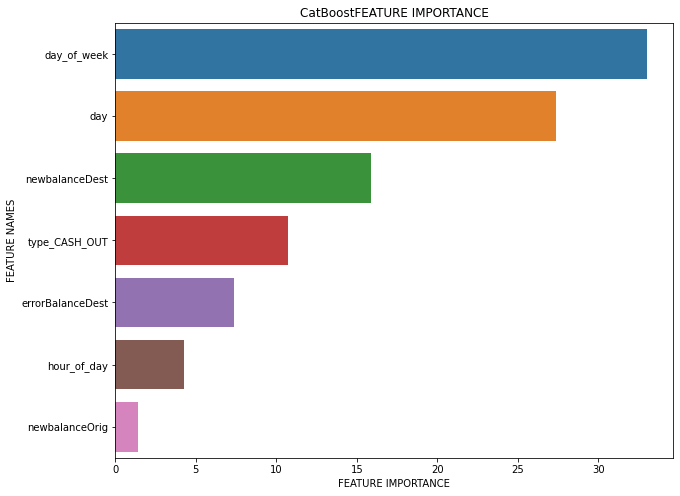

In [ ]:
#plot the catboost result
plot_feature_importance(cb.feature_importances_, X_train.columns, 'CatBoost')

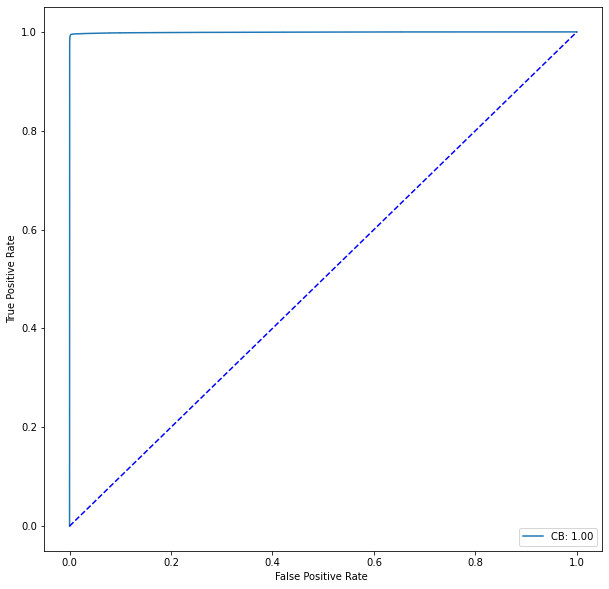

In [ ]:
pred_prob_cb = cb.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_cb[:, 1]], ['CB'])

### LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
lgb = LGBMClassifier(n_estimators=1000, max_depth=25, learning_rate=0.01, eval_metric='auc', objective='binary', boosting='gbdt')
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)
y_pred = lgb.predict(X_train)
print(accuracy_score(y_train, y_pred))
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

In [ ]:
pred_prob_lgb = lgb.predict_proba(X_test.loc[:, column_train])
roc_line([pred_prob_lgb[:, 1]], ['LGB'])

In [ ]:
#plot the lgboost result
plot_feature_importance(lgb.feature_importances_, X_train.columns,'LGB BOOST')

### Q & A:

1. Data cleaning including missing values, outliers and multi-collinearity?
- There are no missing values, Multicollinearity has been removed using VIF and treatment of outliers
  - We can see that there are some variables with high correlation,
  
     - 'errorBalanceOrg' and errorBalanceDest' are highly correlated.
     - 'type_TRANSFER' and 'type_CASH_OUT' high negative correlation.
     - 'oldbalanceDest' and 'newbalanceDest' are highly correlated.
     - columns having high VIF is removed to avoid MultiCollinearity.
     - outliers are treated using Isolation Forest Algorithm.
     
  - We can drop this columns and can do our Further Analysis.

2. Describe your fraud detection model in elaboration?
    - We can either choose XGBoost or CatBoost algorithm. Depending upon latency Xgboost is good and depending upon predicting frauds CatBoost has overperformed XGBoost in imbalance dataset. Both having AUC of 1.0 with high precision and recall which is a good sign in class imbalance dataset. We are more worried about reducing Recall as this is the ratio of Tp/(TP+FN), where TP = model predicts defaulters and they are defaulters, FN = model predicts payers and actual defaulters. So we need to overcome this.
    - As we have used SMOTE for upsampling minority class, as we had an imbalance dataset DecisionTree, CatBoost, LightGradientBoost and XGBoost are performing good with high recall and precision and now depending upon latency and classifying frauds XGBoost has performed really well compared to CatBoost.  So we can go with XGBoost which is much faster than CatBoost and both perform really well on both imbalance and balance dataset.
    - Decision Tree overfitted and XGBoost performed well compared to LightGradientBoost and CatBoost in classifying Frauds and Non-Frauds.
    - XGBoost has high Precision and Recall and AUC of 1.0 which indicates about model performance being good.

3. How did you select variables to be included in the model?
    - By looking at data there are lot of points which deosn't talk to each other like some points have both oldbalanceDest and newbalanceDest being equal to '0' even though they have amount that has been transferred. So to overcome this I went with an variable errorBalanceOrig and errorBalanceDest which is difference of newbalance and oldbalance to find patterns. As we know the fraudulent agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. If we see any transfer of large amount from 'Origin' to 'Destination' then the error will be large which indicates of an uncertain event.

4. Demonstrate the performance of the model by using best set of tools?
    - Recall and Precision are very which means model has done good in classifying most of the Frauds happened and AUC score of 1.0 indicates about False positive rate(FPR) and True positive rate(TPR) are very high indicating model has captured most of the points correctly.

5. What are the key factors that predict fraudulent customer?
    - type='CASH_OUT' is an important factor as it indicates if there is any cash withdrawal from account.

6. Do these factors make sense? If yes, How? If not, How not?
    - 'CASH_OUT' is an important factor as fraudsters tend to cash out as soon as possible so that no one can track them and they use the Money for their needs. If they keep the Money idle the bank may interfere and block the account of fraudster to recollect the amount and deposit in related customer account.

7. What kind of prevention should be adopted while company update its infrastructure?
  - Mobile Banking apps with Fingerprint, Email to customer to visit bank, Message alerts with 'Yes/No' or 'OTP' options, Visiting banks to withdraw lumpsum amount, Update Password and to choose strong Password and not share 'OTP' or 'CVV', Apply ML and AI to see the pattern of Frauds.

8. Assuming these actions have been implemented, how would you determine if they work?
    - 1.To overcome these banks needs to educate the customer and also there should be limit set for transcations made in a month and for Online mode transactions like Mobile banking, Credit card, Debit card.
    - 2.If customers need to withdraw a lumpsum amount then they should visit banks and fill the details and can withdraw the amount. This will help banks and customers from frauds happening for sure.
    - 3.Email customer to visit bank and verify about the transactions made.
    - 4.Use of Fingerprint in banking apps should be implemented and Message to registered mobile number of the customer before withdrawing Money to alert the customer about his transaction with 'Yes/No' option or 'OTP' where 'Yes' means it is the customer who is doing the transaction and 'No' means it is from other source so that bank can track that and stop transfer of amount or customer needs to Enter 'OTP' to withdraw money from Internet Banking, ATM, Online Transactions of Debit and Credit Cards.
    - 5. Advice customers to reguraly update Password and to choose strong Password and not share 'OTP' or 'CVV'.
    - 6.Applying ML and AI technology to find the pattern of Frauds like huge transactions happening within short period of time trigger it and flag it, find out transfer of large amount within short period of time which indicates an uncertain activity(event).
    These ways can definitely minimize the fraudulent activities as they are updating the customers about their transaction history and they can inform banks about any transaction that is not done by them by visiting banks. 